In [1]:
%load_ext autoreload
%autoreload 1
import sys
import os
sys.path.append("../..")

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset

from ntupleReaders.clue_ntuple_reader import ClueNtupleReader
%aimport ml.calibration.energy_distribution_from_weights
from ml.calibration.energy_distribution_from_weights import WeightedLayersComputations
from ml.plot_utils import plotLossPerEpoch

/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu/lib/python3.10/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
reader = ClueNtupleReader("v40", "cmssw", "sim_proton_v46_patchMIP")
full_dataset = TensorDataset(*torch.load(os.path.join(reader.pathToFolder, "energyPerLayer.pt")))

In [3]:
totalev = len(full_dataset)
ntrain = int(0.8*totalev)
ntest = totalev - ntrain

ntrainbatch = 200
ntestbatch = 100
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [ntrain, ntest])
trainloader = DataLoader(train_dataset, batch_size=ntrainbatch, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=ntestbatch, shuffle=True)

In [4]:
class Model(torch.nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):
        
        super().__init__()
        # initialize weights with random numbers
        #weights = torch.distributions.Uniform(0, 0.1).sample((3,))
        #weights = torch.ones(size=(28,),requires_grad=True,dtype=torch.float)
        weights = torch.normal(mean=torch.ones(size=(28,)), std=torch.ones(size=(28,))*0.5)
        # make weights torch parameters
        self.weights = torch.nn.Parameter(weights)        
        
    def forward(self, X):
        """Implement function to be optimised.
        """
        batch_size = X.shape[0]
        output = X*self.weights.repeat(batch_size,1) # tensor (batchItem, layer) with weighted energy for each layer
        return torch.sum(output,dim=-1) # sum energies over all layer per item

In [5]:
#device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

mse = torch.nn.MSELoss()
def lossComputation(result:torch.Tensor, trueBeamEnergy:torch.Tensor):
    # return mse(result, data[1])  # Loss is MSE of E_estimate - E_beam
    return mse(result/trueBeamEnergy, torch.ones_like(result))  # Loss is MSE of E_estimate / E_beam wrt to 1


lossc,lossr = [],[]
epochs = []
opt = torch.optim.Adam(model.parameters(), lr=0.001)
#opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#opt = torch.optim.SGD(model.parameters(), lr=1e-1)#, nesterov=True)

def train(epoch):
    model.train()
    #torch.cuda.empty_cache()
    #scheduler.step()
    loss = []
    for data in tqdm(trainloader):
            data[0] = data[0].to(device)
            data[1] = data[1].to(device)
            optimizer.zero_grad()
            result = model(data[0])

            lossc = lossComputation(result, data[1])

            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            #scheduler.batch_step()
    print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    return np.mean(np.array(loss))



def evaluate(epoch):
    model.eval()
    #torch.cuda.empty_cache()
    #scheduler.step()
    loss = []
    pred = []
    true = []
    calc = []
    for data in tqdm(testloader):
            data[0] = data[0].to(device)
            data[1] = data[1].to(device)
            #print(data[0])
            optimizer.zero_grad()
            result = model(data[0])
            #print(result)
            lossc = lossComputation(result, data[1])
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            #scheduler.batch_step()
            for i in result:
                pred.append(i.detach().cpu())
                #predc.append(i.detach().cpu().argmax())
            for i in data[1].detach():
                true.append(i.detach().cpu())
            for i in data[0].detach():
                calc.append(torch.sum(i.detach().cpu()))    
    
    if False:
        from matplotlib.pyplot import figure
        figure(figsize=(15, 15), dpi=40)
        #plt.rcParams['axes.labelsize'] = 36
        #plt.rcParams['axes.titlesize'] = 36
        #plt.hist2d(truea,preda,bins=200)
        #plt.scatter(truea,preda,alpha=0.4)
        #plt.scatter(truea,preda,alpha=0.4)
        
        plt.hist(np.array(pred)/np.array(true),bins=100,range=[0.75,1.25],label='pred')
        plt.hist(np.array(calc)/np.array(true),bins=100,range=[0.75,1.25],label='calc')
        #plt.plot([0,2], [0,2], 'k-')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        #plt.xlim([-2, 18])
        #plt.ylim([-2, 20])
        plt.axvline(x=1.0,c='r')
        #plt.axhline(y=1.0,c='r')
        plt.legend()
        plt.show()
    
    
    print( 'batches for test:',len(loss)) 
    print('test loss:',np.mean(np.array(loss)))
    print("calib weights:",model.weights)
    return np.mean(np.array(loss))




epoch: 0


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.002324272059073772


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.0008919035649579809
calib weights: Parameter containing:
tensor([0.4006, 1.4128, 0.8454, 1.0868, 1.4096, 1.0369, 0.4511, 1.4007, 1.1702,
        0.8512, 0.6766, 1.3873, 0.7000, 1.1380, 1.4747, 1.0027, 1.0912, 0.6047,
        1.3244, 1.3318, 1.4387, 0.9437, 0.7206, 1.0664, 0.9945, 0.7397, 0.2211,
        0.3372], device='cuda:0', requires_grad=True)
new best test loss: 0.0008919035649579809
epoch: 1


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.0008484035131160586


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.00082588191696606
calib weights: Parameter containing:
tensor([0.5239, 1.3096, 0.8284, 1.0242, 1.2924, 1.0438, 0.5901, 1.3571, 1.1601,
        0.9233, 0.7716, 1.3302, 0.7623, 1.0883, 1.3281, 0.9604, 1.0237, 0.6459,
        1.2205, 1.2460, 1.3360, 0.9871, 0.8459, 1.1601, 1.1260, 0.9573, 0.5750,
        0.7340], device='cuda:0', requires_grad=True)
new best test loss: 0.00082588191696606
epoch: 2


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.0008006516406118284


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.0007839554361274526
calib weights: Parameter containing:
tensor([0.7362, 1.2494, 0.8899, 1.0060, 1.1616, 1.0510, 0.7659, 1.2416, 1.0939,
        0.9812, 0.8743, 1.2278, 0.8633, 1.0539, 1.1757, 0.9751, 1.0047, 0.7869,
        1.1417, 1.1799, 1.2276, 1.0578, 0.9978, 1.2388, 1.2297, 1.1483, 0.9048,
        1.1715], device='cuda:0', requires_grad=True)
new best test loss: 0.0007839554361274526
epoch: 3


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.0007720554596250495


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.0007653171977073038
calib weights: Parameter containing:
tensor([0.8555, 1.1871, 0.9410, 1.0083, 1.0786, 1.0580, 0.8932, 1.1486, 1.0415,
        1.0182, 0.9430, 1.1444, 0.9401, 1.0414, 1.0791, 1.0019, 1.0027, 0.9013,
        1.0815, 1.1220, 1.1278, 1.0758, 1.0562, 1.2164, 1.2223, 1.2027, 1.0551,
        1.4780], device='cuda:0', requires_grad=True)
new best test loss: 0.0007653171977073038
epoch: 4


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.0007625432568355272


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.0007601453407053062
calib weights: Parameter containing:
tensor([0.9187, 1.1417, 0.9692, 1.0160, 1.0402, 1.0619, 0.9592, 1.1001, 1.0180,
        1.0372, 0.9757, 1.0974, 0.9809, 1.0367, 1.0310, 1.0206, 1.0052, 0.9681,
        1.0519, 1.0994, 1.0771, 1.0878, 1.0873, 1.2015, 1.2061, 1.2264, 1.1295,
        1.7125], device='cuda:0', requires_grad=True)
new best test loss: 0.0007601453407053062
epoch: 5


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.0007605438515108574


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.0007589758357577832
calib weights: Parameter containing:
tensor([0.9554, 1.1097, 0.9848, 1.0220, 1.0216, 1.0633, 0.9887, 1.0755, 1.0073,
        1.0448, 0.9897, 1.0731, 0.9979, 1.0330, 1.0078, 1.0299, 1.0066, 0.9986,
        1.0352, 1.0815, 1.0497, 1.0885, 1.0969, 1.1771, 1.1813, 1.2299, 1.1585,
        1.8909], device='cuda:0', requires_grad=True)
new best test loss: 0.0007589758357577832
epoch: 6


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.0007598984433817869


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.0007584504094047279
calib weights: Parameter containing:
tensor([0.9709, 1.0900, 0.9941, 1.0271, 1.0135, 1.0635, 1.0032, 1.0659, 1.0045,
        1.0489, 0.9962, 1.0621, 1.0069, 1.0348, 1.0002, 1.0392, 1.0081, 1.0179,
        1.0312, 1.0823, 1.0414, 1.0985, 1.1141, 1.1779, 1.1785, 1.2296, 1.1702,
        2.0266], device='cuda:0', requires_grad=True)
new best test loss: 0.0007584504094047279
epoch: 7


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.0007597835891696663


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.0007588456630100176
calib weights: Parameter containing:
tensor([0.9789, 1.0745, 0.9911, 1.0208, 1.0007, 1.0566, 1.0036, 1.0550, 0.9998,
        1.0504, 0.9985, 1.0595, 1.0110, 1.0387, 0.9973, 1.0435, 1.0106, 1.0244,
        1.0268, 1.0755, 1.0334, 1.0982, 1.1142, 1.1665, 1.1645, 1.2156, 1.1781,
        2.1179], device='cuda:0', requires_grad=True)
epoch: 8


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.0007598592857216041


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.0007588636590157342
calib weights: Parameter containing:
tensor([0.9912, 1.0717, 0.9990, 1.0286, 1.0059, 1.0612, 1.0117, 1.0558, 1.0008,
        1.0519, 1.0007, 1.0561, 1.0112, 1.0344, 0.9925, 1.0387, 1.0071, 1.0261,
        1.0234, 1.0715, 1.0286, 1.0951, 1.1165, 1.1618, 1.1648, 1.2142, 1.1850,
        2.1918], device='cuda:0', requires_grad=True)
epoch: 9


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.0007597779102590201


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.000758382575456356
calib weights: Parameter containing:
tensor([0.9938, 1.0695, 1.0022, 1.0296, 1.0044, 1.0614, 1.0115, 1.0535, 0.9997,
        1.0507, 0.9995, 1.0537, 1.0124, 1.0347, 0.9939, 1.0417, 1.0101, 1.0325,
        1.0245, 1.0749, 1.0293, 1.1009, 1.1203, 1.1586, 1.1665, 1.2122, 1.1841,
        2.2459], device='cuda:0', requires_grad=True)
new best test loss: 0.000758382575456356


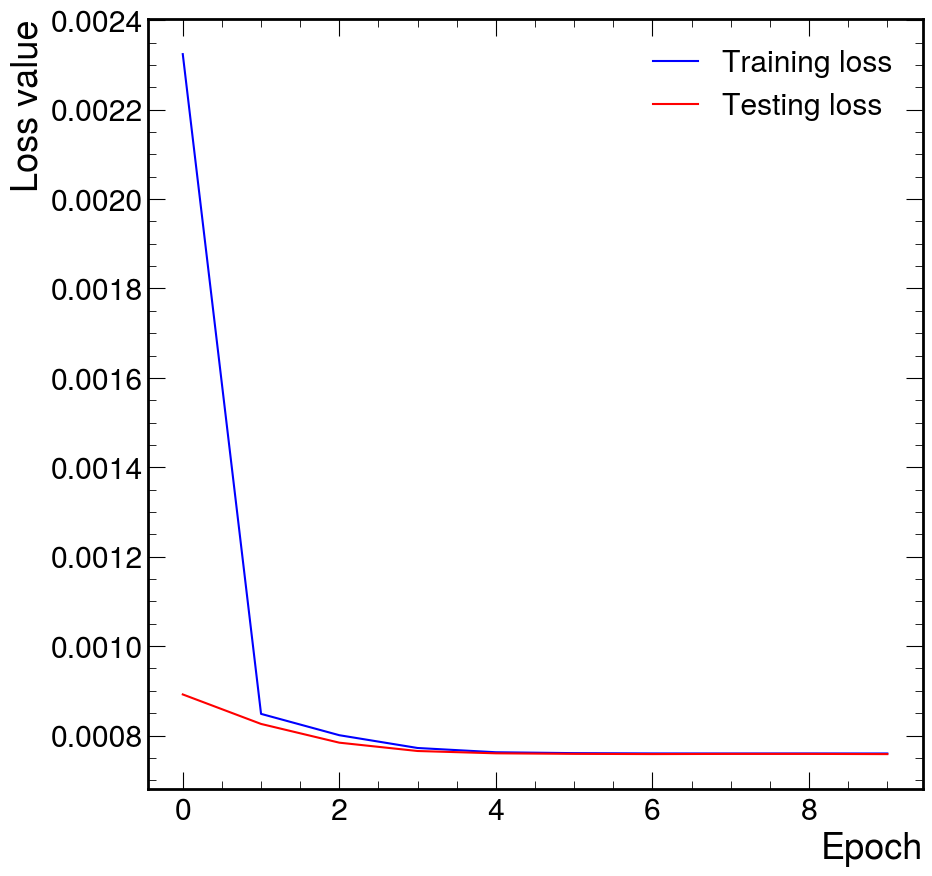

In [6]:
nepoch=10
#os.makedirs(checkpoint_dir, exist_ok=True)
best_loss = 99999999
losst = []
lossv = []
epochs = []
for epoch in range(nepoch):
    print ('epoch:',epoch)
    losst.append(train(epoch))
    loss_epoch = evaluate(epoch)
    lossv.append(loss_epoch)
    epochs.append(epoch)
    #checkpoint = {
    #'epoch': epoch + 1,
    #'state_dict': model.state_dict(),
    #'optimizer': optimizer.state_dict()
    #}
    
    #checkpoint_file = 'model_epoch_%i.pth.tar' % ( epoch )
    #torch.save(checkpoint,
    #               os.path.join(checkpoint_dir,checkpoint_file ))
    if loss_epoch < best_loss:
        best_loss = loss_epoch
        print('new best test loss:',best_loss)
        #torch.save(checkpoint,
        #           os.path.join(checkpoint_dir,'model_checkpoint_best.pth.tar' ))
    if ((epoch+1)%10 == 0):
        plotLossPerEpoch(epochs, losst, lossv)

In [14]:
parameters = list(model.parameters())[0].detach().cpu().numpy()
weightsAsDict = dict(zip(range(1, 28+1), parameters))
parameters

array([0.98079437, 1.0756853 , 0.9979116 , 1.0203333 , 1.001333  ,
       1.0504475 , 1.0119241 , 1.059458  , 0.99849343, 1.048409  ,
       1.0042281 , 1.0500176 , 1.006712  , 1.0212137 , 0.99453604,
       1.0482845 , 1.0179821 , 1.035587  , 1.0255342 , 1.0767683 ,
       1.0345027 , 1.1002198 , 1.1042557 , 1.155234  , 1.1686363 ,
       1.2159553 , 1.1574708 , 2.3919706 ], dtype=float32)

In [15]:
del model

In [11]:
weightedComp = WeightedLayersComputations(weightsAsDict, reader)

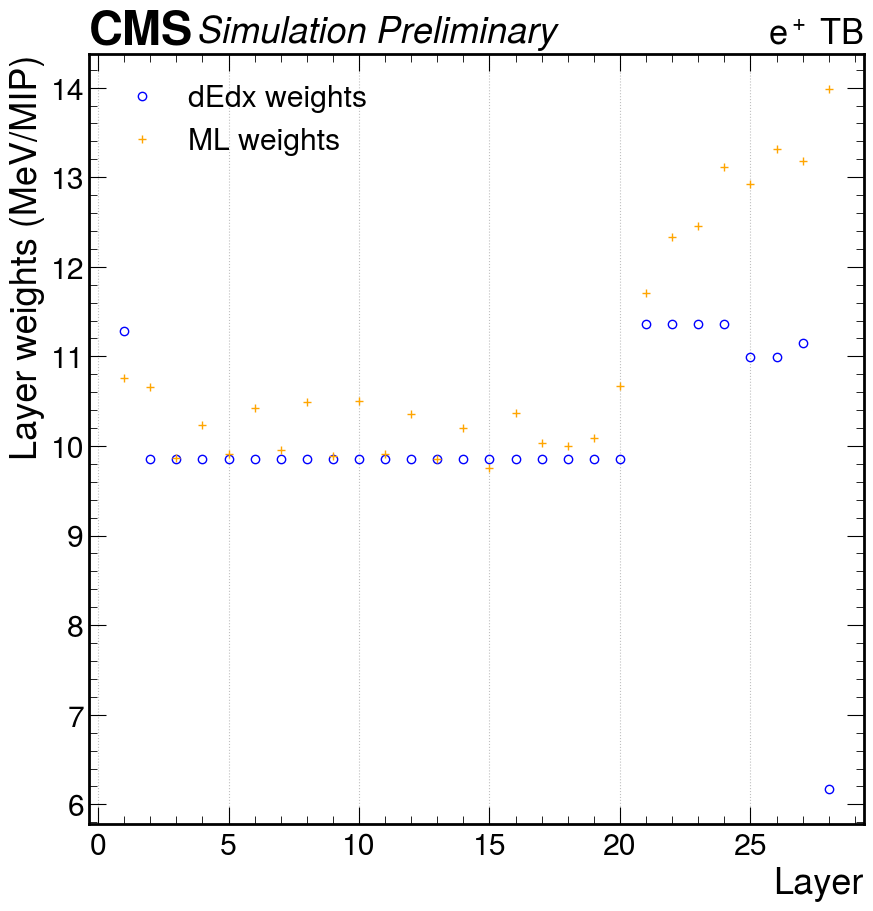

In [ ]:
import importlib
import ml.calibration.energy_distribution_from_weights
importlib.reload(ml.calibration.energy_distribution_from_weights).WeightedLayersComputations.plotDeDxWeights(weightedComp)
None

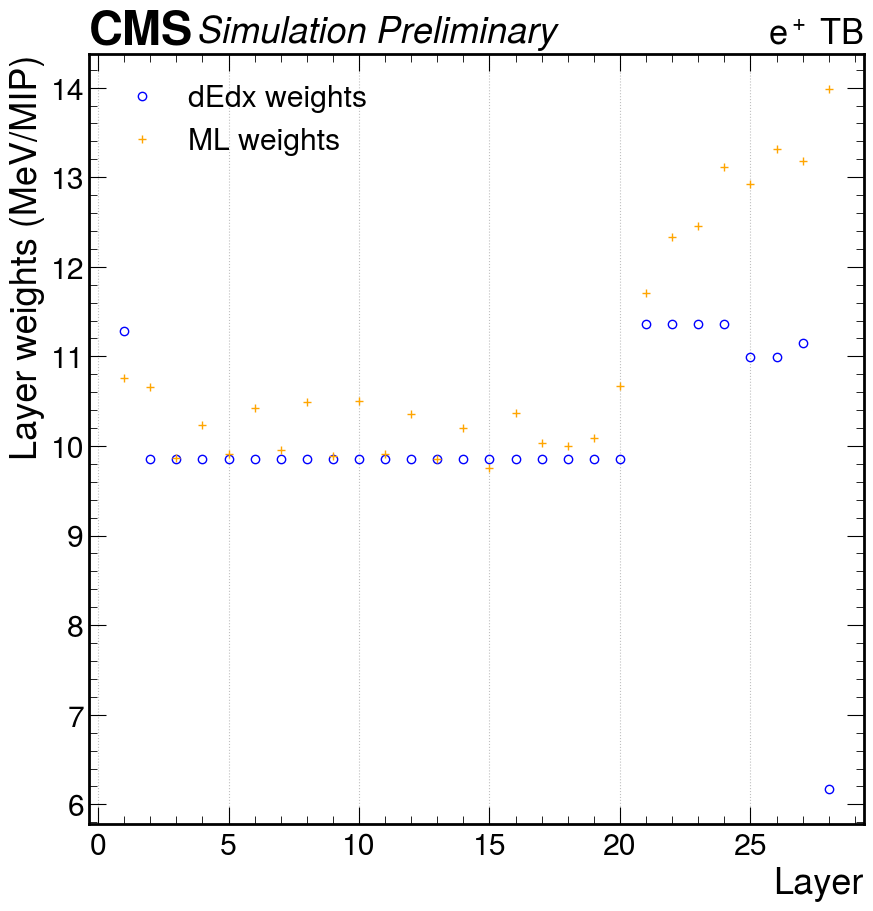

In [ ]:
weightedComp.plotDeDxWeights()
None # NB : in longitudinal profiles, even layer have a dip, odd have a bump

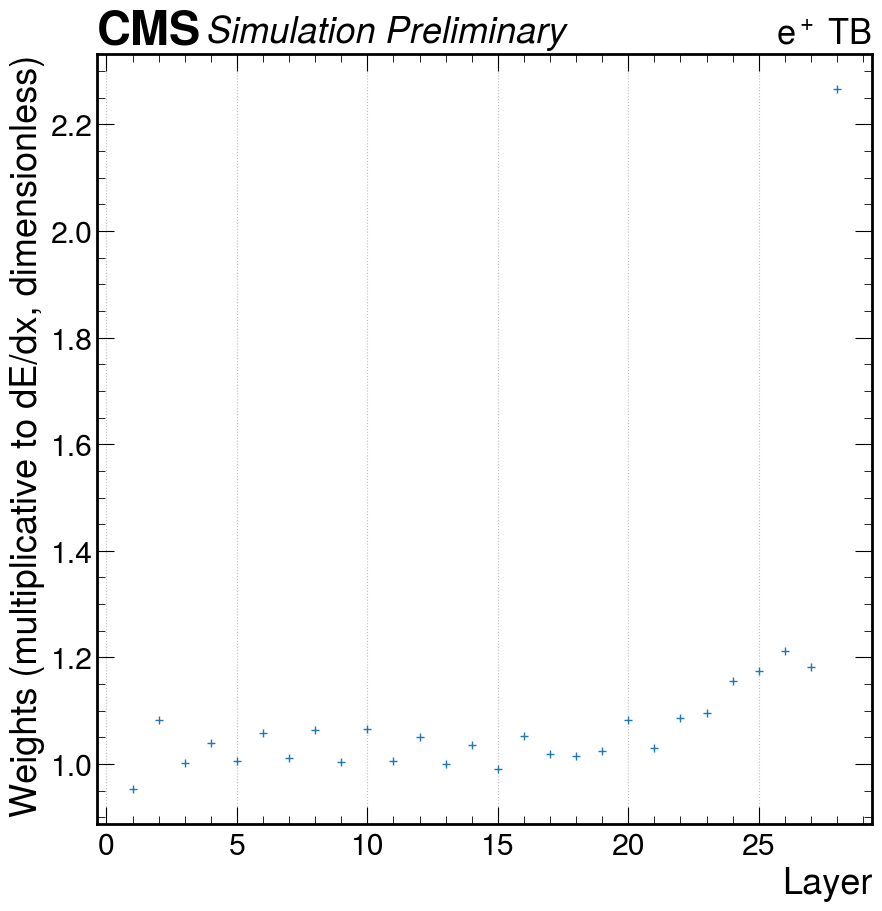

In [ ]:
weightedComp.plotRelativeWeights()
None

In [ ]:
weightedComp.compute()

Histogramming with weighted layers:   0%|          | 0/359937 [00:00<?, ?it/s]

Fitting:   0%|          | 0/10 [00:00<?, ?it/s]

Iterative fitting - 20 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 30 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 50 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 80 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 100 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 120 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 149 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 198 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 244 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 288 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

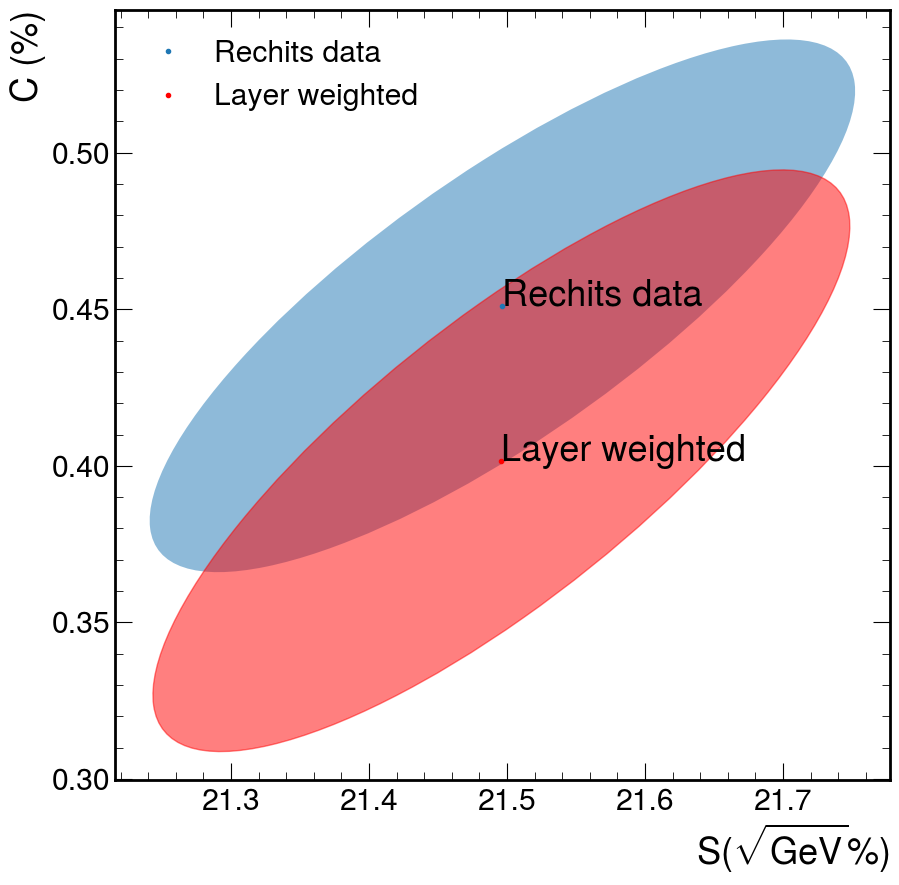

In [ ]:
weightedComp.plotEllipse()
None

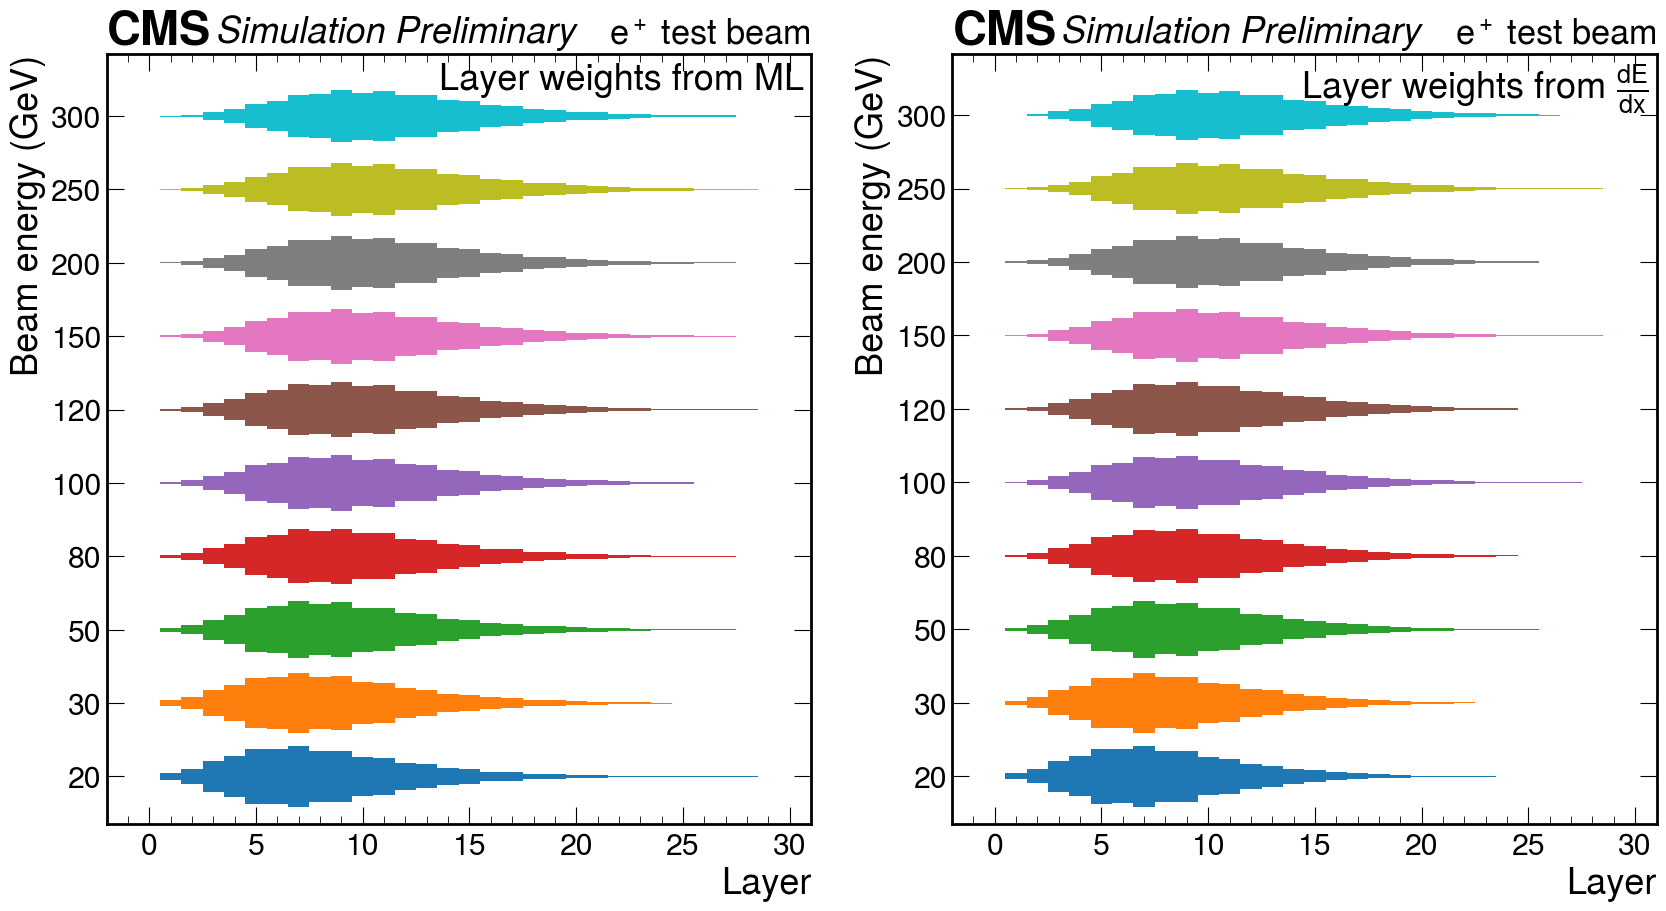

In [ ]:
weightedComp.plotViolin()
None